In [1]:
import multiprocessing as mp
mp.set_start_method('forkserver',force=True)

import random
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as T
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
import arviz as az

In [2]:
tox21_two_assays = pd.read_csv("../data/two-assay-example.csv")

# Single assay example with 3 features

In [28]:
one_assay = tox21_two_assays[tox21_two_assays['PROTOCOL_NAME'] == 'tox21-ar-mda-kb2-luc-agonist-p3']

In [29]:
one_assay.head()

,PROTOCOL_NAME,CHANNEL_OUTCOME,SAMPLE_NAME,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,tox21-ar-mda-kb2-luc-agonist-p3,inactive,Imipenem,11.938415,-1.104254,11.938415,0.052549,0.224452,299.352,282.216,...,1,0,0,0,0,0,0,0,2,0
1,tox21-ar-mda-kb2-luc-agonist-p3,inactive,Quinapril hydrochloride,13.260918,-1.036043,13.260918,0.000000,0.542299,474.985,443.737,...,0,0,0,0,0,0,0,0,0,0
2,tox21-ar-mda-kb2-luc-agonist-p3,inactive,Diphenoxylate hydrochloride,13.076853,-0.710688,13.076853,0.000000,0.369982,489.059,455.795,...,0,0,0,0,0,0,0,0,0,0
3,tox21-ar-mda-kb2-luc-agonist-p3,inactive,Eperisone hydrochloride,12.391306,0.000000,12.391306,0.000000,0.766044,295.854,269.646,...,0,0,0,0,0,0,0,0,0,0
4,tox21-ar-mda-kb2-luc-agonist-p3,inactive,Pranoprofen,11.024948,-0.820607,11.024948,0.513338,0.764395,255.273,242.169,...,0,0,0,0,0,0,0,0,0,0


In [30]:
X = one_assay.iloc[:,3:]
y = one_assay.CHANNEL_OUTCOME

In [34]:
#Select three features at random
X_bayes = one_assay[['FpDensityMorgan2', 'BCUT2D_LOGPLOW','FractionCSP3']]

#Need to add intercept column for algebra to work
X_bayes.insert(0,'Intercept',1)
X_bayes = np.asarray(X_bayes)
Y_bayes = pd.factorize(one_assay.CHANNEL_OUTCOME)

## Mathematical notation of single level bayesian logistic regression 
$$ Y \sim Bernoulli(\mu)$$
$$ \mu = g^{-1}(X\beta)$$
$$\beta  \sim N(0,3.0)$$



In [35]:
with pm.Model() as logistic_model:
    betas = pm.Normal('betas', mu=0.0, sigma=3.0, shape=4)
    p = 1.0 / (1.0 + T.exp(-T.dot(X_bayes, betas)))
    likelihood = pm.Bernoulli('likelihood', p, observed=Y_bayes[0])
    

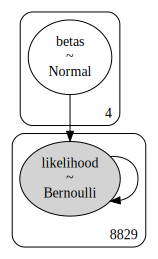

In [36]:
pm.model_to_graphviz(logistic_model)

### Running the model

In [37]:
#NOTE: this is far from optimized/tuned -- the warnings are important to follow up when doing this for real
with logistic_model:
    tr = pm.sample(500,tune=500,cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [betas]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 469 seconds.
The acceptance probability does not match the target. It is 0.8906, but should be close to 0.8. Try to increase the number of tuning steps.


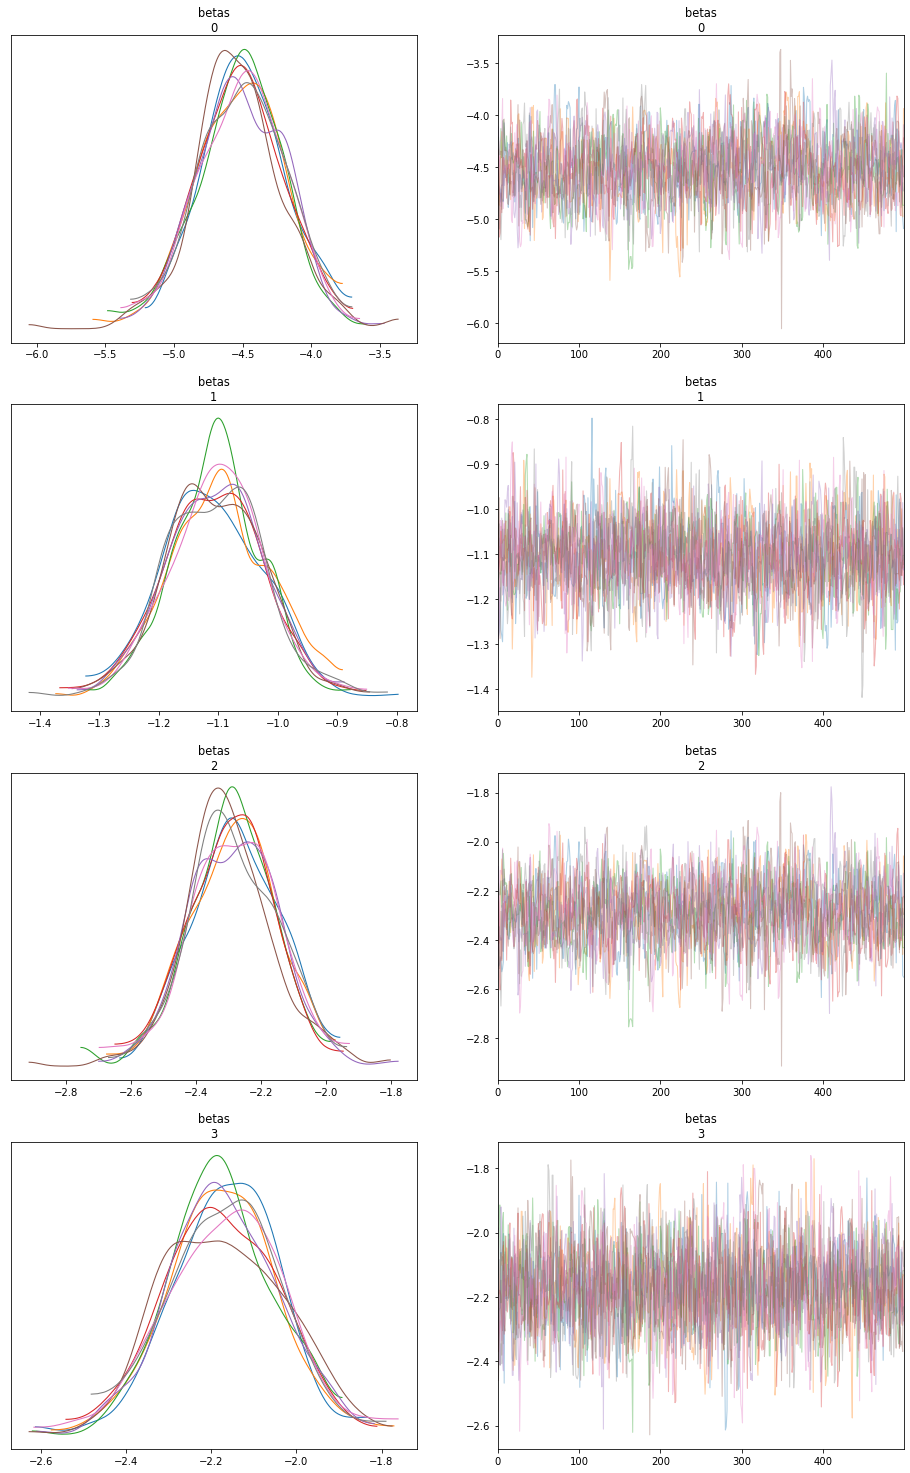

In [38]:
with logistic_model:
    az.plot_trace(tr,compact=False, figsize=(16,26))

## Two assay example with random intercept and random slope

In [46]:
protocols = pd.factorize(tox21_two_assays.PROTOCOL_NAME)

In [47]:
list(protocols[1])

['tox21-ar-mda-kb2-luc-agonist-p3', 'tox21-ar-mda-kb2-luc-antagonist-p1']

In [48]:
X2_bayes = tox21_two_assays[['FpDensityMorgan2', 'BCUT2D_LOGPLOW','FractionCSP3']]

#Need to add intercept column for algebra to work
X2_bayes.insert(0,'Intercept',1)

#pymc seems to really prefer numpy arrays
X2_bayes = np.asarray(X2_bayes)
Y2_bayes = pd.factorize(tox21_two_assays.CHANNEL_OUTCOME)

In [49]:
X2_bayes[:,0]

array([1., 1., 1., ..., 1., 1., 1.])

In [50]:
#Convenience dictionary for pymc syntax
coords = {
    'obs_id': np.arange(X2_bayes.shape[0]),
    'protocol':list(protocols[1]),
    'params':['beta_{0}'.format(i) for i in range(X2_bayes.shape[1])]
}
print(coords)

{'obs_id': array([    0,     1,     2, ..., 18496, 18497, 18498]), 'protocol': ['tox21-ar-mda-kb2-luc-agonist-p3', 'tox21-ar-mda-kb2-luc-antagonist-p1'], 'params': ['beta_0', 'beta_1', 'beta_2', 'beta_3']}


## Mathematical notation of the random slope and intercept model
$$ Y \sim Bernoulli(\mu)$$
$$ \mu = g^{-1}(X\beta_{prot})$$
$$\beta_{prot} \sim MvNormal(\beta,\Sigma)$$
$$\beta \sim N(0,3.0)$$

In [51]:
#https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html
with pm.Model(coords=coords) as random_slope_model:
    protocol_idx = pm.Data("protocol_idx", list(protocols[0]),dims='obs_id')
    
    # prior stddev in intercepts & slopes (variation across protocol):
    sd_dist = pm.Exponential.dist(1)
    
    # get back standard deviations and rho:
    #https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/LKJ.html
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=X2_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    #priors for average betas:
    beta_list = []
    for i in range(X2_bayes.shape[1]):
        beta_list.append(pm.Normal('beta_{0}'.format(i), mu=0.0,sigma=3.0))
    
    #population of varying protocol effects:
    beta_protocol = pm.MvNormal("beta_protocol", mu=T.stack(beta_list), chol=chol,dims=('protocol','params'))
    
    #Expected value per protocol:
    theta = beta_protocol[protocol_idx,0]* X2_bayes[:,0]
    for i in range(1,X2_bayes.shape[1]):
        theta += beta_protocol[protocol_idx,i] * X2_bayes[:,i]

    p = 1.0 / (1.0 + T.exp(-theta ))
    likelihood = pm.Bernoulli('likelihood', p, observed=Y2_bayes[0],dims="obs_id")


/data/sanjakjs/conda/envs/pymc_env2/lib/python3.9/site-packages/pymc/data.py:647: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


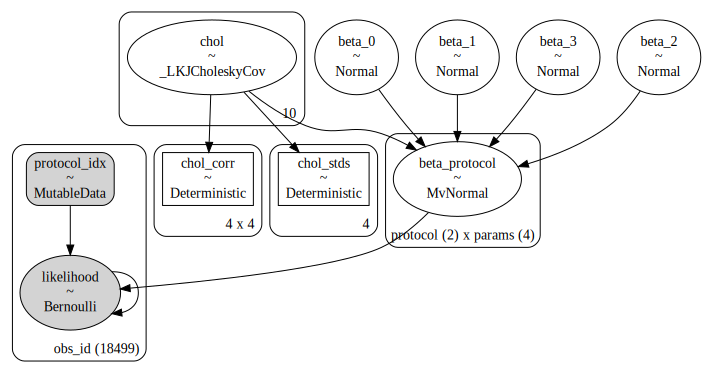

In [52]:
pm.model_to_graphviz(random_slope_model)

### Running the model -- warning can take a while

In [53]:
with random_slope_model:
    tr = pm.sample(500, tune=500, init="adapt_diag",chains=4,cores=8)


/data/sanjakjs/conda/envs/pymc_env2/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/data/sanjakjs/conda/envs/pymc_env2/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to th

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 953 seconds.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6049, but should be close to 0.8. Try to increase the number of tuning steps.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
There were 215 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5582, but should be close to 0.8. Try to increase the number of tuning steps.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess

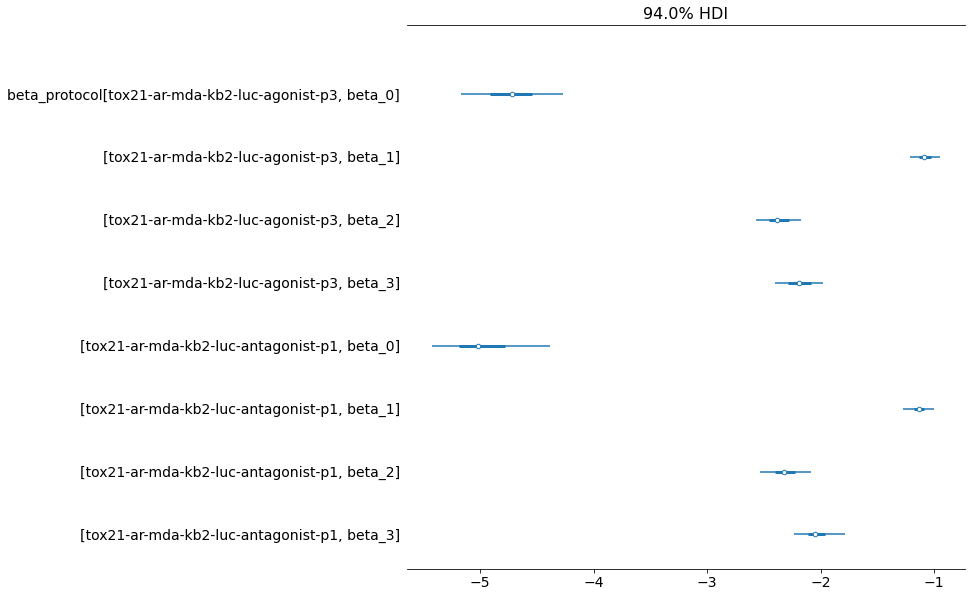

In [54]:
with random_slope_model:
    az.plot_forest(
        tr,
        combined=True,
        var_names=["beta_protocol"],
        figsize=(10, 10),
        textsize=14,
    )

## Construct an assay level variable and simulate two additional assays to create a 4 assay model with an assay level predictor

In [ ]:
tox21_two_assays.head()

In [ ]:
organism = ['human' for i in range(tox21_two_assays.shape[0])] + ['mouse' for i in range(tox21_two_assays.shape[0])]

In [ ]:
new_protocol = [i + '-' + v for i,v in zip(pd.concat([tox21_two_assays['PROTOCOL_NAME'],tox21_two_assays['PROTOCOL_NAME']]),organism)]

In [ ]:
tox21_two_assays['CHANNEL_OUTCOME'].value_counts()

In [ ]:
simulated_two_assays = tox21_two_assays.copy()
fp_density_scale = (simulated_two_assays['FpDensityMorgan2'] - simulated_two_assays['FpDensityMorgan2'].min()) / (simulated_two_assays['FpDensityMorgan2'].max() - simulated_two_assays['FpDensityMorgan2'].min())
fp_density_scale

new_outcome = []
for i,v in zip(simulated_two_assays['CHANNEL_OUTCOME'],fp_density_scale/10.0):
    rv = random.random()
    if i == "inactive":
        if (rv + v)>1:
            print((i,v,rv,rv+v))
            new_outcome.append('active antagonist')
        else:
            new_outcome.append(i)
    else:
        if (rv + v)<0.1:
            print((i,v,rv,rv+v))
            new_outcome.append('inactive')
        else:
            new_outcome.append(i)

simulated_two_assays['CHANNEL_OUTCOME'] = new_outcome

In [ ]:
simulated_two_assays['CHANNEL_OUTCOME'].value_counts()

In [ ]:
four_assay_simulated = pd.concat([tox21_two_assays,simulated_two_assays])
four_assay_simulated['PROTOCOL_NAME'] = new_protocol
four_assay_simulated.insert(2,'ORGANISM',organism)
four_assay_simulated.reset_index(drop=True,inplace=True)

In [ ]:
four_assay_simulated.head()

In [ ]:
four_assay_simulated.tail()

In [ ]:
simulated_protocols = pd.factorize(four_assay_simulated.PROTOCOL_NAME)

In [ ]:
#To busy to figure out the right way to do this
organisms = [0,0,1,1]

In [ ]:
X4_bayes = four_assay_simulated[['FpDensityMorgan2', 'BCUT2D_LOGPLOW','FractionCSP3']]
X4_bayes.insert(0,'Intercept',1)
X4_bayes = np.asarray(X4_bayes)
Y4_bayes = pd.factorize(four_assay_simulated.CHANNEL_OUTCOME)

In [ ]:
coords_simulated = {
    'obs_id': np.arange(X4_bayes.shape[0]),
    'protocol':list(simulated_protocols[1]),
    'params':['beta_{0}'.format(i) for i in range(X4_bayes.shape[1])]
}

## Mathematical notation of the multi-level model
$$ Y \sim Bernoulli(\mu)$$
$$ \mu = g^{-1}(X\beta_{prot})$$
$$\beta_{prot} \sim MvNormal(\mu_{prot},\Sigma)$$
$$\mu_{prot} = \gamma_0 + \gamma_1 * organism + \epsilon$$
$$\gamma_{i} \sim N(0,\sigma^{2}_{\gamma})$$
$$\epsilon \sim N(0,\sigma^{2}_{\epsilon})$$


In [ ]:
#https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html
with pm.Model(coords=coords_simulated) as assay_level_model:
    protocol_idx = pm.Data("protocol_idx", list(simulated_protocols[0]),dims='obs_id')
    organism_idx = pm.Data("organism_idx", organisms, dims="protocol")
    
    # prior stddev in intercepts & slopes (variation across protocol):
    sd_dist = pm.Exponential.dist(1)
    
    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=X4_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    #hyperpriors and priors for average betas:
    beta_list = []
    for i in range(X4_bayes.shape[1]):
        gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=2)
        mu_gbeta = gbeta[0] + gbeta[1] * organism_idx
        beta_list.append(pm.Normal('beta_{0}'.format(i), mu=mu_gbeta,sigma=3.0,dims="protocol"))
    
    #population of varying protocol effects:
    beta_protocol = pm.MvNormal("beta_protocol", mu=T.stack(beta_list), chol=chol,dims=('protocol','params'))
    
    #Expected value per protocol:
    theta = beta_protocol[protocol_idx,0]* X4_bayes[:,0]
    for i in range(1,X4_bayes.shape[1]):
        theta += beta_protocol[protocol_idx,i] * X4_bayes[:,i]

    p = 1.0 / (1.0 + T.exp(-theta ))
    likelihood = pm.Bernoulli('likelihood', p, observed=Y4_bayes[0],dims="obs_id")

In [ ]:
pm.model_to_graphviz(assay_level_model)

### Running the model -- warning this can take hours

In [ ]:
with assay_level_model:
    tr_assay = pm.sample(500, tune=500, init="adapt_diag",chains=4,cores=8)


In [ ]:
with assay_level_model:
    az.plot_forest(
        tr_assay,
        combined=True,
        var_names=["beta_protocol"],
        figsize=(10, 10),
        textsize=14,
    )